<a href="https://colab.research.google.com/github/DanilYachmenev/For_Fun_Pepe_Recognition/blob/master/PepeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64

In [0]:
# Uploading .csv files with images URLs

In [0]:
folder_1 = 'pepe'
file_1 = 'urls_pepe.csv'

In [0]:
folder_2 = 'toad'
file_2 = 'urls_toad.csv'

In [0]:
folder_3 = 'froggo'
file_3 = 'urls_froggo.csv'

In [0]:
# Creating folders and assigning destinations to the files

In [0]:
path = Path('froggos_project_1/froggos_1')

dest_1 = path/folder_1
dest_2 = path/folder_2
dest_3 = path/folder_3

In [0]:
dest_1.mkdir(parents=True, exist_ok=True)
dest_2.mkdir(parents=True, exist_ok=True)
dest_3.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

[PosixPath('froggos_project_1/froggos_1/pepe'),
 PosixPath('froggos_project_1/froggos_1/froggo'),
 PosixPath('froggos_project_1/froggos_1/toad')]

In [0]:
# Downloading images by URLs in the kernel

In [0]:
download_images(path/file_1, dest_1, max_pics=200)
download_images(path/file_2, dest_2, max_pics=200)
download_images(path/file_3, dest_3, max_pics=200)

In [0]:
# Defining classes

In [0]:
classes = [folder_1, folder_2, folder_3] 

In [0]:
classes

['pepe', 'toad', 'froggo']

In [0]:
# Creating DataBunch and split data on training and validation sets

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, bs = bs).normalize(imagenet_stats)

In [0]:
data.classes

['froggo', 'pepe', 'toad']

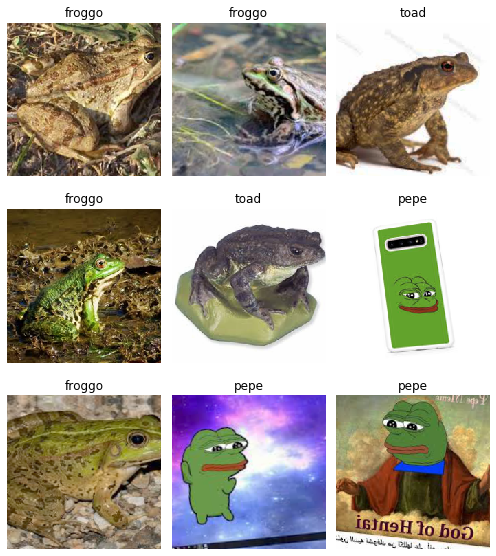

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['froggo', 'pepe', 'toad'], 3, 480, 120)

In [0]:
# Making initial model. Error rate on basic resnet34 is 6.67%

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.123446,0.263928,0.075000,00:05
1,0.654070,0.247840,0.066667,00:04
2,0.473334,0.224641,0.066667,00:04
3,0.375135,0.227955,0.066667,00:04


In [0]:
learn.save('stage-1')

In [0]:
# Looking at top losses we can see that sometimes differentiation is hard, but it is working pretty good

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

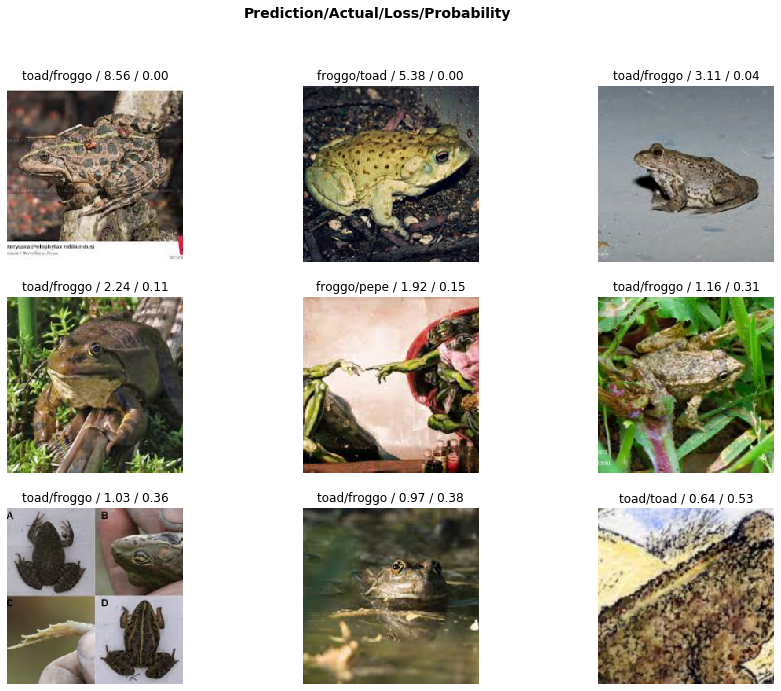

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

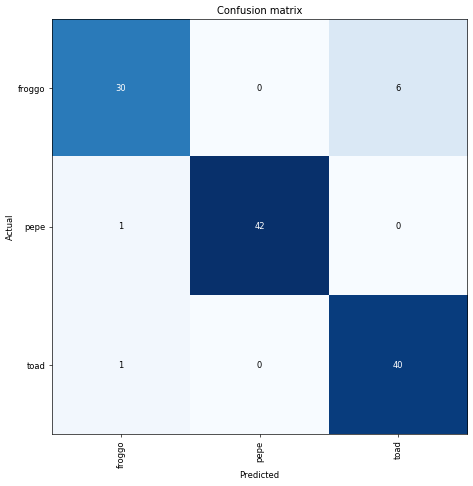

In [0]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [0]:
interp.most_confused(min_val=1)

[('froggo', 'toad', 6), ('pepe', 'froggo', 1), ('toad', 'froggo', 1)]

In [0]:
# Improving model by adjusting learning rate

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [0]:
# By plotting learning rate we can find and choose the value of lr, where loss is decining on the fastest rate.
# This allows us to choose therate, at which the model will learn fast and will not overfit.

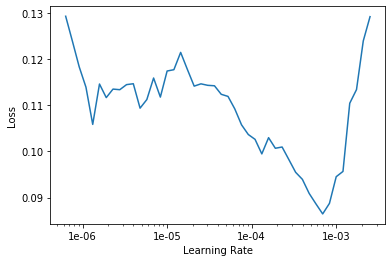

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.054520,0.410636,0.075000,00:04
1,0.047759,0.237243,0.058333,00:04
2,0.035859,0.232632,0.058333,00:04
3,0.029188,0.227129,0.050000,00:04


In [0]:
# As we see, lr adjustment allowed us to improve our accuracy and now wehave eroor rate just 5%.
# While it is supposedly not a hard work for a model to distinguish Pepe from frogs and toads, we have to pay credit for a high accuracy of the model
# in separating toads and frogs from each other, which is not that trivial.

In [0]:
learn.save('stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [0]:
# As we see some images are truly misguiding, so their removal would improve our model accuracy even more.
# Although even with this pictures the result is already surprisingly accurate.

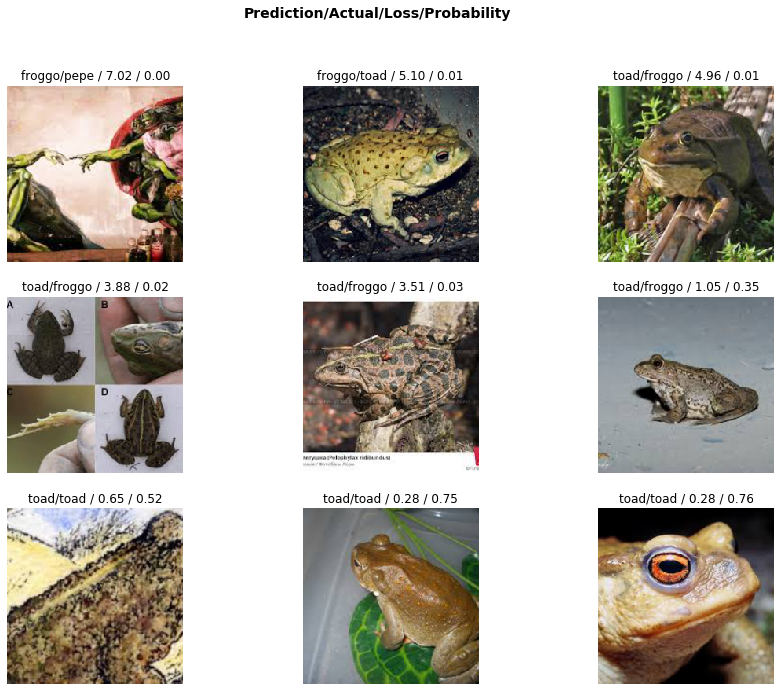

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

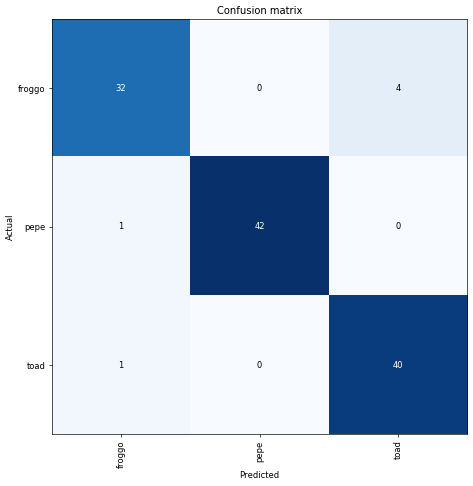

In [0]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [0]:
learn.export()

In [0]:
# Let's try our model on some new pictures it has never seen.

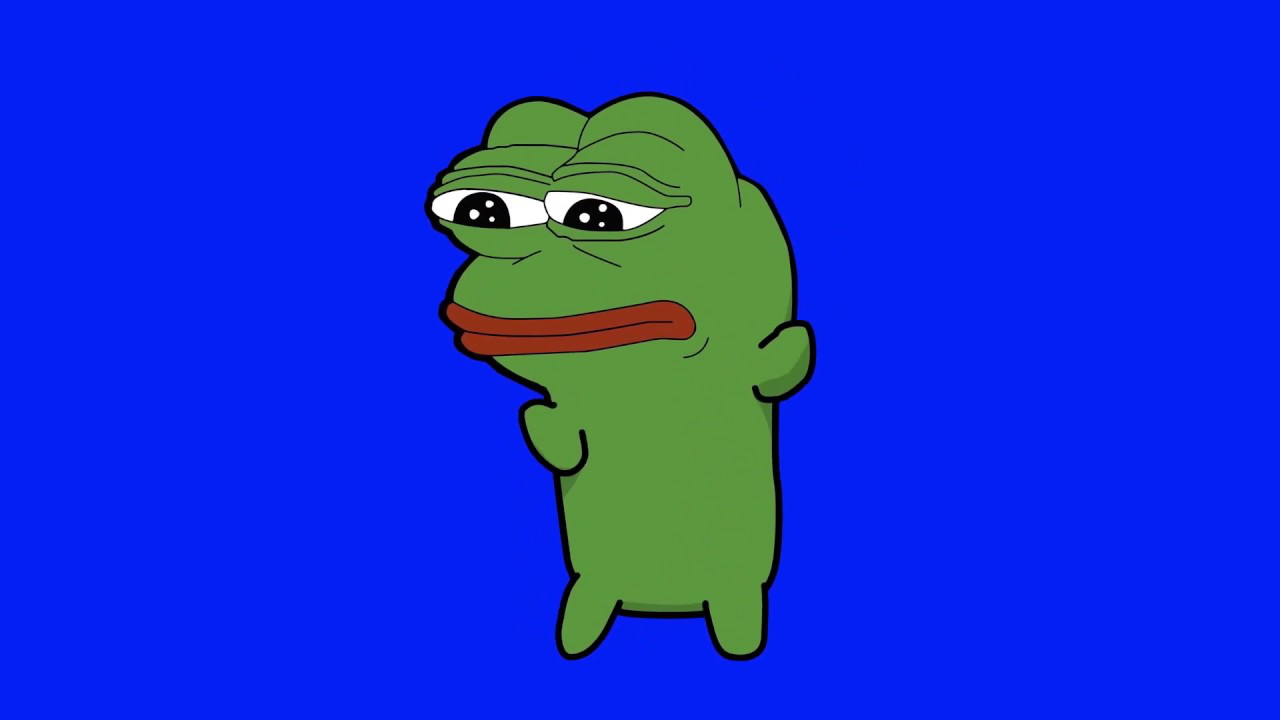

In [0]:
img = open_image(path/'maxresdefault.jpg')
img

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category pepe

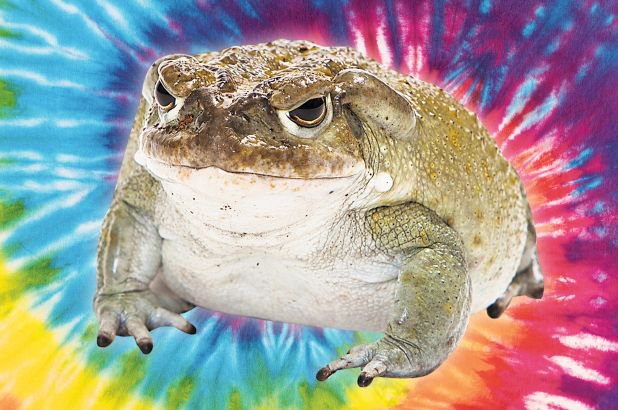

In [0]:
img_1 = open_image(path/'toadimage.jpg')
img_1

In [0]:
pred_class,pred_idx,outputs = learn.predict(img_1)
pred_class

Category toad

In [0]:
# Looks like it is working!
# So if for whatever reason you might need to distinguish frogs, toads and Pepes, you can freely use this code

# P.S. this small project was made as my first step in image classification, but further on I'll do something more useful (though you might think what else could be?!)
# I hope